In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
import tensorflow as tf
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [ ]:
image_directory = '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/'
mask_directory = '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_masks/'

In [ ]:
SIZE = 256
num_images = 1000

Carregando imagens do google drive em ordem númerica




In [ ]:
image_names = glob.glob("/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/*.png")

In [ ]:
image_names.sort()
print(image_names)

['/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image_1.png', '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image_10.png', '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image_100.png', '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image_1000.png', '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image_1001.png', '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image_1002.png', '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image_1003.png', '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image_1004.png', '/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_images/augmented_image

In [ ]:
image_names_subset = image_names[0:num_images]

In [ ]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [ ]:
image_dataset = np.array(images)
image_dataset = image_dataset/255
image_dataset = np.expand_dims(image_dataset, axis = 3)

Carregando as masks da mesma forma


In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/aug_masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
(thresh,mask_dataset) = cv2.threshold(mask_dataset, 127, 255, cv2.THRESH_BINARY)
mask_dataset = mask_dataset/255
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is :", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Max pixel value in mask is: ", mask_dataset.max())
print("Min pixel value in image is: ", image_dataset.min())
print("Min pixel value in mask is: ", mask_dataset.min())
print("Labels in the mask are: ", np.unique(mask_dataset))
print()

Image data shape is:  (1000, 384, 384, 1)
Mask data shape is : (1000, 384, 384, 1)
Max pixel value in image is:  1.0
Max pixel value in mask is:  1.0
Min pixel value in image is:  0.0
Min pixel value in mask is:  0.0
Labels in the mask are:  [0. 1.]



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


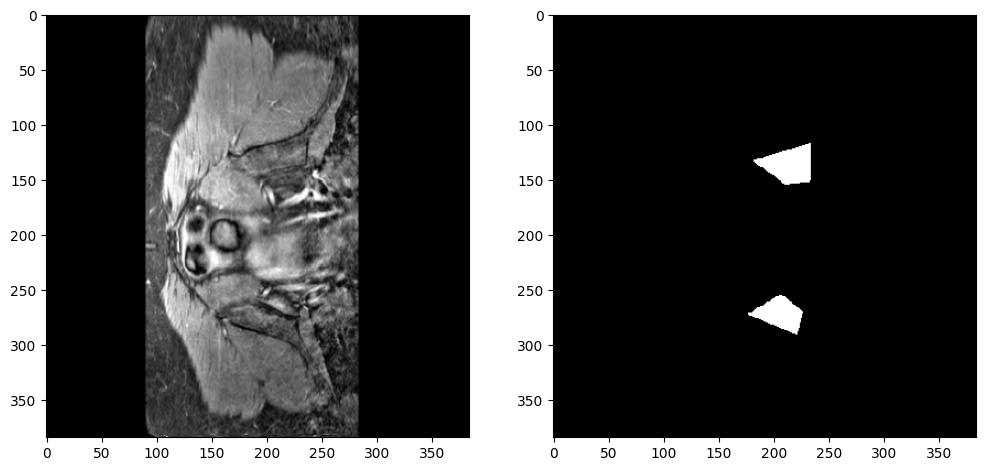

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 8,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    shuffle=False)


Epoch 1/100
100/100 [==============================] - 34s 145ms/step - loss: 0.2244 - accuracy: 0.9342 - val_loss: 3.4949 - val_accuracy: 0.9571
Epoch 2/100
100/100 [==============================] - 14s 137ms/step - loss: 0.1566 - accuracy: 0.9560 - val_loss: 0.5214 - val_accuracy: 0.9571
Epoch 3/100
100/100 [==============================] - 14s 137ms/step - loss: 0.1352 - accuracy: 0.9556 - val_loss: 0.1466 - val_accuracy: 0.9571
Epoch 4/100
100/100 [==============================] - 14s 137ms/step - loss: 0.1194 - accuracy: 0.9561 - val_loss: 0.1978 - val_accuracy: 0.9571
Epoch 5/100
100/100 [==============================] - 14s 137ms/step - loss: 0.1095 - accuracy: 0.9577 - val_loss: 0.2428 - val_accuracy: 0.9571
Epoch 6/100
100/100 [==============================] - 14s 137ms/step - loss: 0.1025 - accuracy: 0.9605 - val_loss: 0.4129 - val_accuracy: 0.6985
Epoch 7/100
100/100 [==============================] - 14s 137ms/step - loss: 0.0945 - accuracy: 0.9632 - val_loss: 0.3714 -

In [ ]:
#Save the model for future use
model.save("/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/100epochs.hdf5")

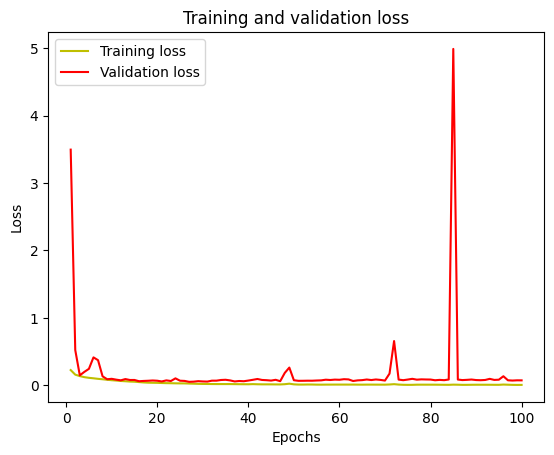

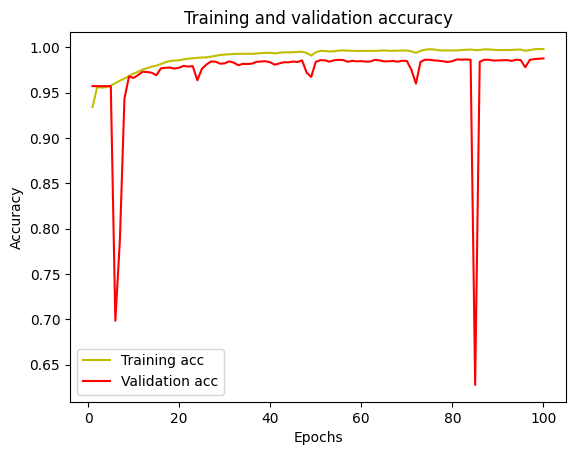

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/tcc imagens redimensionadas/HCFMRP_sacroiliitis_v1/100epochs.hdf5", compile=False)

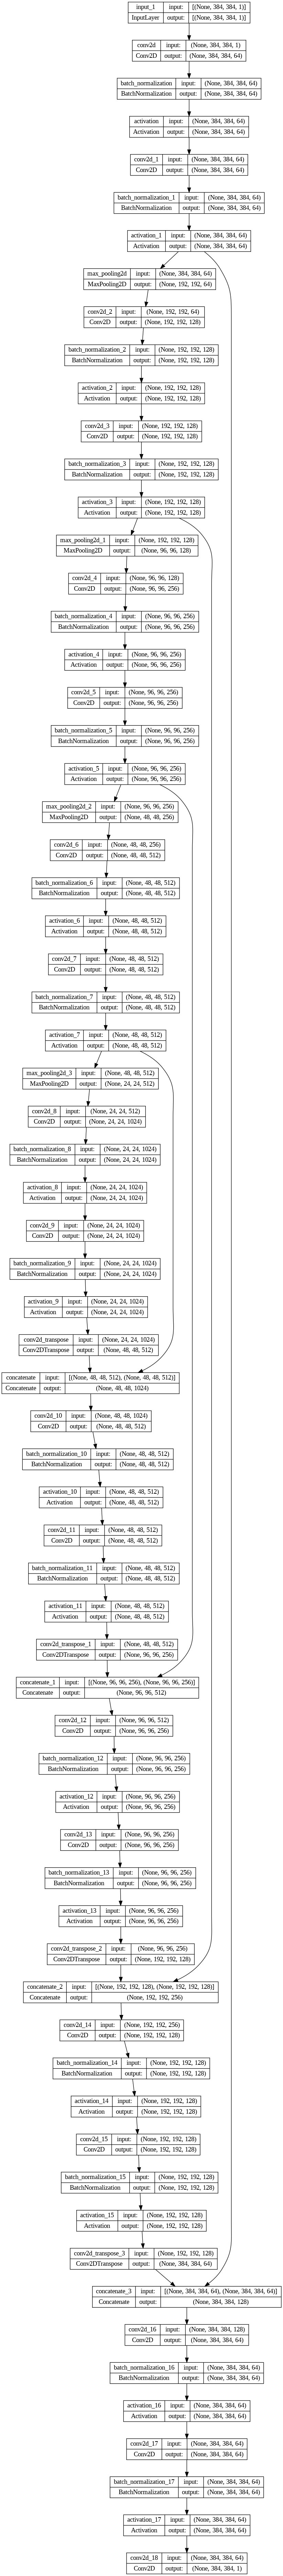

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#IOU and SD
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

7/7 [==============================] - 12s 114ms/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU

Valor da Intersection over union obtido:

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.85882986


In [ ]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


In [ ]:
iou_scores = []
for y_true, y_pred in zip(y_test, y_pred_thresholded):
    iou_scores.append(calculate_iou(y_true, y_pred))


In [ ]:
iou_std = np.std(iou_scores)
print("Std IoU =", iou_std)


Std IoU = 0.10885118141476328


(1, 384, 384, 1)
1/1 [==============================] - 1s 742ms/step
(384, 384)


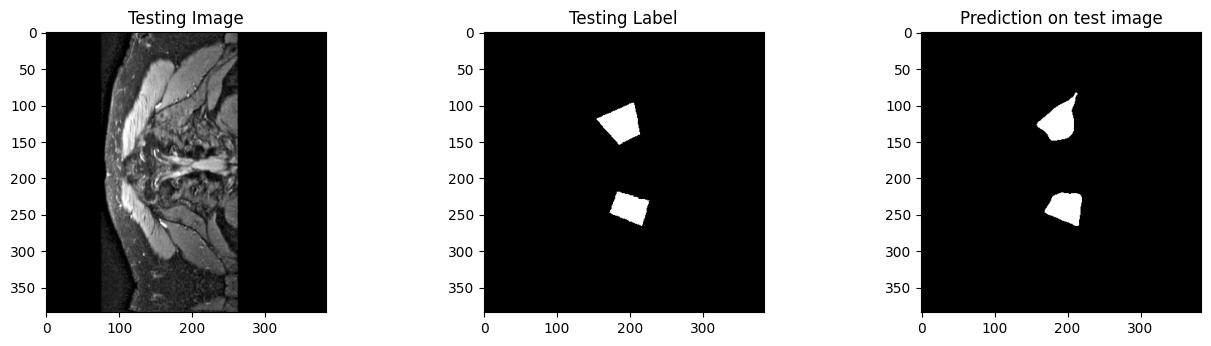

In [ ]:
#plot testing label x predicted label
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()